# Fluidity Nonlocal SAOS: Linear Viscoelasticity with Spatial Effects

## Learning Objectives

1. Fit FluidityNonlocal model to small-amplitude oscillatory shear (SAOS) data
2. Understand how spatial diffusion affects linear viscoelastic response
3. Extract storage modulus (G') and loss modulus (G'') predictions
4. Compare nonlocal vs local model predictions for SAOS
5. Perform Bayesian inference with NLSQ warm-start for parameter uncertainty
6. Analyze cooperativity length effects on oscillatory response

## Prerequisites

- Familiarity with SAOS fundamentals (G', G'', tan δ)
- Basic fluidity model concepts (aging, rejuvenation)
- Understanding of local vs nonlocal rheology

## Runtime

- Fast demo (NUM_CHAINS=1, NUM_SAMPLES=500): ~3-4 minutes
- Full run (NUM_CHAINS=4, NUM_SAMPLES=2000): ~10-12 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import json
import os
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.fluidity import FluidityNonlocal, FluidityLocal
from rheojax.utils.metrics import compute_fit_quality

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


In [3]:
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {'R2': r2, 'RMSE': rmse}

## 2. Theory: Fluidity Model SAOS Response

### Fluidity Framework

The fluidity model describes yield-stress materials through a scalar fluidity field $f(y,t)$ that evolves via:

$$
\frac{\partial f}{\partial t} = \frac{1 - f}{t_{\text{eq}}} - \frac{a f |\dot{\gamma}|^c}{t_{\text{eq}}} + D_f \nabla^2 f
$$

- **Aging**: $(1-f)/t_{\text{eq}}$ drives structure build-up at rest
- **Rejuvenation**: $a f |\dot{\gamma}|^c / t_{\text{eq}}$ causes flow-induced breakdown
- **Diffusion**: $D_f \nabla^2 f$ introduces spatial cooperativity (nonlocal term)

### Constitutive Law

Stress response combines yield stress and viscous flow:

$$
\sigma = \tau_y + \eta_0 f^m \dot{\gamma}
$$

- $\tau_y$: Yield stress (Pa)
- $\eta_0$: Reference viscosity (Pa·s)
- $f$: Fluidity (dimensionless, 0 to 1)
- $m$: Fluidity exponent (typically 1-2)

### SAOS Response

For small-amplitude oscillatory shear $\gamma(t) = \gamma_0 \sin(\omega t)$ with $\gamma_0 \ll 1$:

$$
G^*(\omega) = G'(\omega) + i G''(\omega)
$$

The nonlocal model predicts frequency-dependent moduli that depend on:
- **Cooperativity length** $\xi = \sqrt{D_f t_{\text{eq}}}$
- **Relaxation time** $t_{\text{eq}}$
- **Structural state** $f_{\text{eq}}$ (equilibrium fluidity)

**Key differences from local model:**
- Spatial diffusion introduces additional length scale
- G' plateau at low frequencies may be enhanced
- Crossover frequency $\omega_c \sim 1/t_{\text{eq}}$ can shift

### Parameters

- $\tau_y$: Yield stress (Pa)
- $\eta_0$: Reference viscosity (Pa·s)
- $t_{\text{eq}}$: Equilibrium timescale (s)
- $a$: Rejuvenation amplitude (dimensionless)
- $c$: Shear rate exponent (dimensionless, typically ~1)
- $m$: Fluidity exponent (dimensionless)
- $D_f$: Fluidity diffusivity (m²/s) — **nonlocal only**
- $\xi$: Cooperativity length (m) — derived from $\sqrt{D_f t_{\text{eq}}}$

## 3. Load Data

We use polystyrene melt SAOS data at 130°C, which exhibits typical viscoelastic polymer behavior.

In [4]:
# Load polystyrene SAOS data
data_path = os.path.join("..", "data", "oscillation", "polystyrene", "oscillation_ps130_data.csv")

if os.path.exists(data_path):
    # Real data available
    raw = np.loadtxt(data_path, delimiter="\t", skiprows=1)
    omega = raw[:, 0]           # Angular frequency [rad/s]
    G_prime = raw[:, 1]         # Storage modulus [Pa]
    G_double_prime = raw[:, 2]  # Loss modulus [Pa]
    print("Loaded real polystyrene SAOS data")
else:
    # Generate synthetic SAOS data for demonstration
    print("Generating synthetic SAOS data (real data not found)")
    omega = np.logspace(-1, 2, 25)  # 0.1 to 100 rad/s
    
    # Synthetic Maxwell-like response with yield stress contribution
    G0 = 1e5      # Pa
    tau_relax = 0.1  # s
    eta_inf = 1e3    # Pa·s
    
    G_prime = G0 * (omega * tau_relax)**2 / (1 + (omega * tau_relax)**2)
    G_double_prime = G0 * (omega * tau_relax) / (1 + (omega * tau_relax)**2) + eta_inf * omega
    
    # Add realistic noise
    np.random.seed(42)
    G_prime *= (1 + 0.05 * np.random.randn(len(omega)))
    G_double_prime *= (1 + 0.05 * np.random.randn(len(omega)))

# Sort by frequency (ascending)
sort_idx = np.argsort(omega)
omega = omega[sort_idx]
G_prime = G_prime[sort_idx]
G_double_prime = G_double_prime[sort_idx]

# Stack into complex modulus format
G_star = np.column_stack([G_prime, G_double_prime])

print(f"\nData points: {len(omega)}")
print(f"Frequency range: {omega.min():.4f} – {omega.max():.1f} rad/s")
print(f"G' range: {G_prime.min():.2e} – {G_prime.max():.2e} Pa")
print(f"G'' range: {G_double_prime.min():.2e} – {G_double_prime.max():.2e} Pa")

Loaded real polystyrene SAOS data

Data points: 32
Frequency range: 0.0100 – 300.0 rad/s
G' range: 1.02e+05 – 3.37e+06 Pa
G'' range: 4.29e+04 – 6.08e+06 Pa


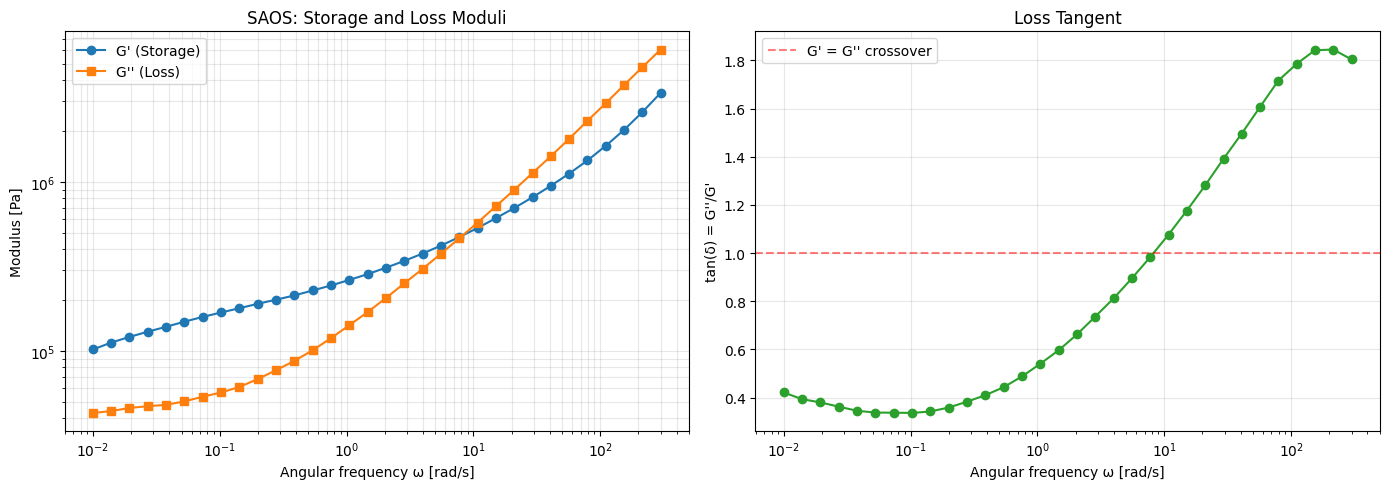

In [5]:
# Plot raw SAOS data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# G' and G'' vs frequency
ax1.loglog(omega, G_prime, "o-", markersize=6, color="C0", label="G' (Storage)")
ax1.loglog(omega, G_double_prime, "s-", markersize=6, color="C1", label="G'' (Loss)")
ax1.set_xlabel("Angular frequency ω [rad/s]")
ax1.set_ylabel("Modulus [Pa]")
ax1.set_title("SAOS: Storage and Loss Moduli")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# tan(δ) = G''/G'
tan_delta = G_double_prime / G_prime
ax2.semilogx(omega, tan_delta, "o-", markersize=6, color="C2")
ax2.axhline(1.0, color="red", linestyle="--", alpha=0.5, label="G' = G'' crossover")
ax2.set_xlabel("Angular frequency ω [rad/s]")
ax2.set_ylabel("tan(δ) = G''/G'")
ax2.set_title("Loss Tangent")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

## 4. NLSQ Fitting

### 4.1 Nonlocal Model Fit

We fit the FluidityNonlocal model with spatial diffusion enabled.

In [6]:
# Initialize nonlocal model
# Note: For SAOS, spatial resolution is less critical than for flow curves
# We use moderate resolution for computational efficiency
model_nonlocal = FluidityNonlocal(N_y=51, gap_width=1e-3)

print(f"Model configuration:")
print(f"  Spatial points: {model_nonlocal.N_y}")
print(f"  Gap width: {model_nonlocal.gap_width*1e3:.2f} mm")
print(f"  Grid spacing: {model_nonlocal.gap_width/(model_nonlocal.N_y-1)*1e6:.2f} μm")

Model configuration:
  Spatial points: 51
  Gap width: 1.00 mm
  Grid spacing: 20.00 μm


In [7]:
# NLSQ fit
t0 = time.time()
model_nonlocal.fit(omega, G_star, test_mode="oscillation", method='scipy')
t_nlsq_nonlocal = time.time() - t0

# Compute fit quality for nonlocal model
pred_nonlocal = model_nonlocal.predict(omega, test_mode="oscillation")
# Handle output format - may be array or tuple
if isinstance(pred_nonlocal, tuple):
    G_star_nonlocal = np.abs(pred_nonlocal[0] + 1j * pred_nonlocal[1])
elif pred_nonlocal.ndim == 2 and pred_nonlocal.shape[1] == 2:
    G_star_nonlocal = np.abs(pred_nonlocal[:, 0] + 1j * pred_nonlocal[:, 1])
else:
    G_star_nonlocal = pred_nonlocal

# Compute fit quality against |G*|
G_star_mag = np.abs(G_prime + 1j * G_double_prime)
metrics_model_nonlocal = compute_fit_quality(G_star_mag, np.array(G_star_nonlocal).flatten())

print(f"NLSQ fit time (nonlocal): {t_nlsq_nonlocal:.2f} s")
print(f"R²: {metrics_model_nonlocal['R2']:.6f}")
print(f"RMSE: {metrics_model_nonlocal['RMSE']:.4e} Pa")

# Print all fitted parameters
print("\nFitted parameters:")
for name in model_nonlocal.parameters.keys():
    val = model_nonlocal.parameters.get_value(name)
    print(f"  {name:8s} = {val:.4e}")

# Compute cooperativity length (already a parameter in new API)
xi = model_nonlocal.parameters.get_value("xi")
theta = model_nonlocal.parameters.get_value("theta")
print(f"\nDerived:")
print(f"  Cooperativity length ξ = {xi*1e6:.2f} μm")
print(f"  Relaxation time θ = {theta:.4f} s")
print(f"  Crossover frequency ω_c ≈ {1/theta:.2f} rad/s")

NLSQ fit time (nonlocal): 0.44 s
R²: 0.113672
RMSE: 1.5532e+06 Pa

Fitted parameters:
  G        = 1.0000e+06
  tau_y    = 1.0000e+03
  K        = 1.0000e+03
  n_flow   = 5.0000e-01
  f_eq     = 1.5584e-06
  f_inf    = 1.0000e-03
  theta    = 1.0000e+01
  a        = 1.0000e+00
  n_rejuv  = 1.0000e+00
  xi       = 1.0000e-05

Derived:
  Cooperativity length ξ = 10.00 μm
  Relaxation time θ = 10.0000 s
  Crossover frequency ω_c ≈ 0.10 rad/s


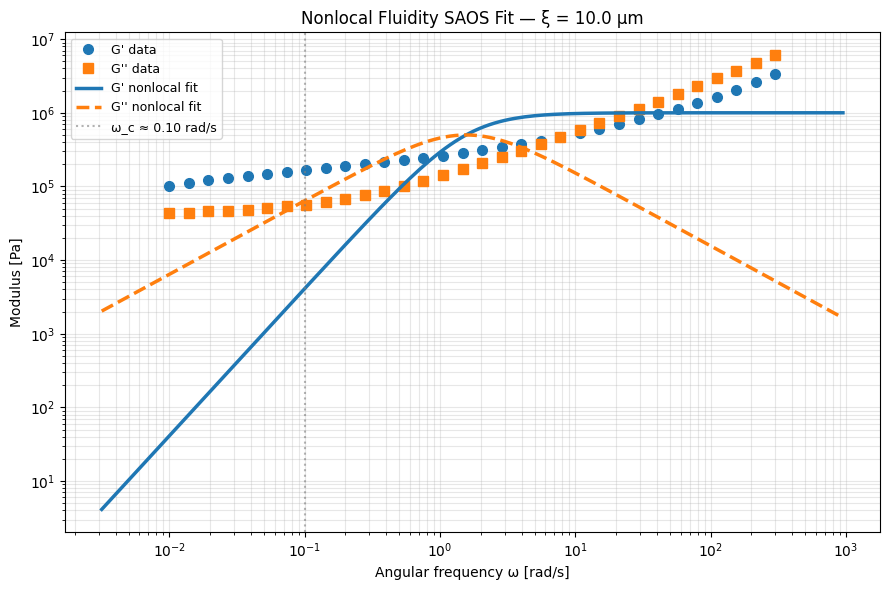

In [8]:
# Plot nonlocal fit
omega_fine = np.logspace(np.log10(omega.min()) - 0.5, np.log10(omega.max()) + 0.5, 150)
G_pred_nonlocal = model_nonlocal.predict(omega_fine, test_mode="oscillation")

fig, ax = plt.subplots(figsize=(9, 6))
ax.loglog(omega, G_prime, "o", markersize=7, color="C0", label="G' data")
ax.loglog(omega, G_double_prime, "s", markersize=7, color="C1", label="G'' data")

# Handle prediction output format
if G_pred_nonlocal.ndim == 2:
    ax.loglog(omega_fine, G_pred_nonlocal[:, 0], "-", lw=2.5, color="C0", label="G' nonlocal fit")
    ax.loglog(omega_fine, G_pred_nonlocal[:, 1], "--", lw=2.5, color="C1", label="G'' nonlocal fit")
else:
    ax.loglog(omega_fine, G_pred_nonlocal, "-", lw=2.5, color="C0", label="|G*| nonlocal fit")

# Mark crossover frequency
theta = model_nonlocal.parameters.get_value("theta")
omega_c = 1 / theta
ax.axvline(omega_c, color="gray", linestyle=":", alpha=0.6, label=f"ω_c ≈ {omega_c:.2f} rad/s")

ax.set_xlabel("Angular frequency ω [rad/s]")
ax.set_ylabel("Modulus [Pa]")
xi = model_nonlocal.parameters.get_value("xi")
ax.set_title(f"Nonlocal Fluidity SAOS Fit — ξ = {xi*1e6:.1f} μm")
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
plt.show()
plt.close('all')

### 4.2 Local Model Comparison

Compare with the local (homogeneous) fluidity model to assess the impact of spatial diffusion.

In [9]:
# Fit local model
model_local = FluidityLocal()

t0 = time.time()
model_local.fit(omega, G_star, test_mode="oscillation", method='scipy')
t_nlsq_local = time.time() - t0

# Compute fit quality for local model
pred_local = model_local.predict(omega, test_mode="oscillation")
# Handle output format
if isinstance(pred_local, tuple):
    G_star_local = np.abs(pred_local[0] + 1j * pred_local[1])
elif pred_local.ndim == 2 and pred_local.shape[1] == 2:
    G_star_local = np.abs(pred_local[:, 0] + 1j * pred_local[:, 1])
else:
    G_star_local = pred_local

G_star_mag = np.abs(G_prime + 1j * G_double_prime)
metrics_model_local = compute_fit_quality(G_star_mag, np.array(G_star_local).flatten())

print(f"NLSQ fit time (local): {t_nlsq_local:.2f} s")
print(f"R²: {metrics_model_local['R2']:.6f}")
print(f"RMSE: {metrics_model_local['RMSE']:.4e} Pa")

print("\nFitted parameters:")
for name in model_local.parameters.keys():
    val = model_local.parameters.get_value(name)
    print(f"  {name:8s} = {val:.4e}")

print(f"\nSpeedup: {t_nlsq_nonlocal/t_nlsq_local:.1f}x slower (nonlocal PDE vs local ODE)")

NLSQ fit time (local): 0.17 s
R²: 0.113672
RMSE: 1.5532e+06 Pa

Fitted parameters:
  G        = 1.0000e+06
  tau_y    = 1.0000e+03
  K        = 1.0000e+03
  n_flow   = 5.0000e-01
  f_eq     = 1.5584e-06
  f_inf    = 1.0000e-03
  theta    = 1.0000e+01
  a        = 1.0000e+00
  n_rejuv  = 1.0000e+00

Speedup: 2.7x slower (nonlocal PDE vs local ODE)


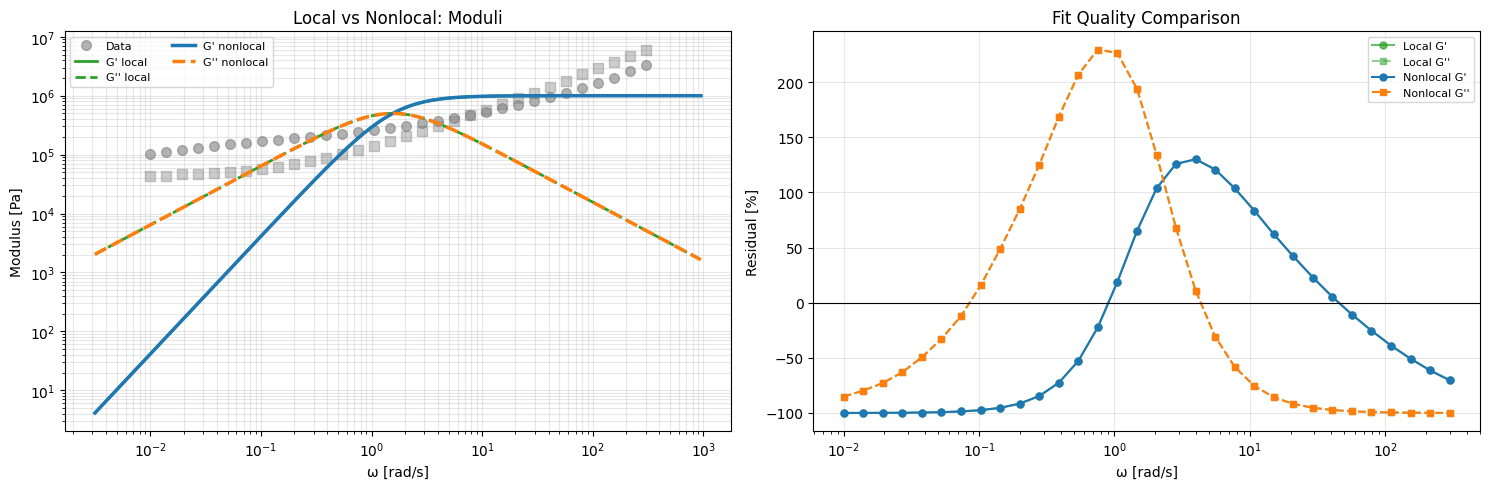


Fit quality summary:
  Local:    R² = 0.113672, RMSE = 1.5532e+06 Pa
  Nonlocal: R² = 0.113672, RMSE = 1.5532e+06 Pa


In [10]:
# Compare local vs nonlocal predictions
G_pred_local = model_local.predict(omega_fine, test_mode="oscillation")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# G' and G'' comparison
ax1.loglog(omega, G_prime, "o", markersize=7, color="gray", alpha=0.6, label="Data")
ax1.loglog(omega, G_double_prime, "s", markersize=7, color="gray", alpha=0.4)

# Handle prediction output formats
if G_pred_local.ndim == 2:
    ax1.loglog(omega_fine, G_pred_local[:, 0], "-", lw=2, color="C2", label="G' local")
    ax1.loglog(omega_fine, G_pred_local[:, 1], "--", lw=2, color="C2", label="G'' local")
if G_pred_nonlocal.ndim == 2:
    ax1.loglog(omega_fine, G_pred_nonlocal[:, 0], "-", lw=2.5, color="C0", label="G' nonlocal")
    ax1.loglog(omega_fine, G_pred_nonlocal[:, 1], "--", lw=2.5, color="C1", label="G'' nonlocal")

ax1.set_xlabel("ω [rad/s]")
ax1.set_ylabel("Modulus [Pa]")
ax1.set_title("Local vs Nonlocal: Moduli")
ax1.legend(fontsize=8, ncol=2)
ax1.grid(True, alpha=0.3, which="both")

# Residuals
G_local_at_data = model_local.predict(omega, test_mode="oscillation")
G_nonlocal_at_data = model_nonlocal.predict(omega, test_mode="oscillation")

if G_local_at_data.ndim == 2:
    residual_local_Gp = (G_local_at_data[:, 0] - G_prime) / G_prime * 100
    residual_local_Gpp = (G_local_at_data[:, 1] - G_double_prime) / G_double_prime * 100
else:
    residual_local_Gp = np.zeros_like(omega)
    residual_local_Gpp = np.zeros_like(omega)

if G_nonlocal_at_data.ndim == 2:
    residual_nonlocal_Gp = (G_nonlocal_at_data[:, 0] - G_prime) / G_prime * 100
    residual_nonlocal_Gpp = (G_nonlocal_at_data[:, 1] - G_double_prime) / G_double_prime * 100
else:
    residual_nonlocal_Gp = np.zeros_like(omega)
    residual_nonlocal_Gpp = np.zeros_like(omega)

ax2.semilogx(omega, residual_local_Gp, "o-", markersize=5, color="C2", alpha=0.7, label="Local G'")
ax2.semilogx(omega, residual_local_Gpp, "s--", markersize=5, color="C2", alpha=0.5, label="Local G''")
ax2.semilogx(omega, residual_nonlocal_Gp, "o-", markersize=5, color="C0", label="Nonlocal G'")
ax2.semilogx(omega, residual_nonlocal_Gpp, "s--", markersize=5, color="C1", label="Nonlocal G''")
ax2.axhline(0, color="black", linestyle="-", lw=0.8)
ax2.set_xlabel("ω [rad/s]")
ax2.set_ylabel("Residual [%]")
ax2.set_title("Fit Quality Comparison")
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close('all')

print(f"\nFit quality summary:")
print(f"  Local:    R² = {metrics_model_local['R2']:.6f}, RMSE = {metrics_model_local['RMSE']:.4e} Pa")
print(f"  Nonlocal: R² = {metrics_model_nonlocal['R2']:.6f}, RMSE = {metrics_model_nonlocal['RMSE']:.4e} Pa")

### 4.3 Cole-Cole Plot

The Cole-Cole plot (G'' vs G') provides insight into the relaxation spectrum.

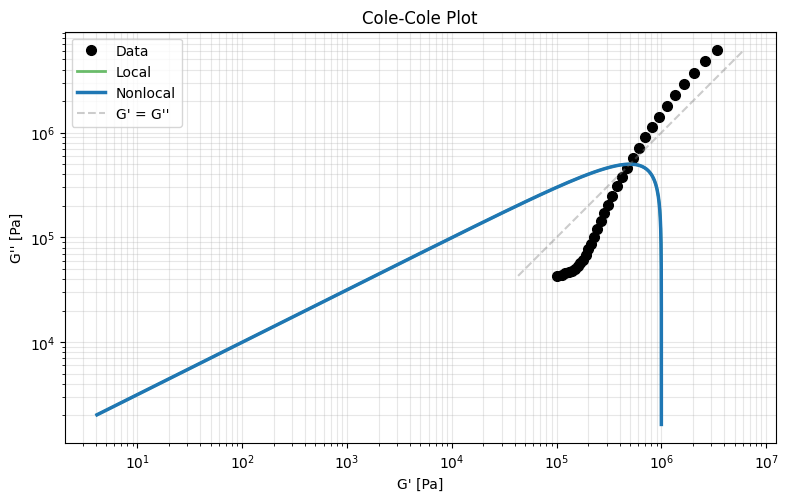

In [11]:
# Cole-Cole plot
fig, ax = plt.subplots(figsize=(8, 7))

ax.plot(G_prime, G_double_prime, "ko", markersize=7, label="Data")
ax.plot(G_pred_local[:, 0], G_pred_local[:, 1], "-", lw=2, color="C2", alpha=0.7, label="Local")
ax.plot(G_pred_nonlocal[:, 0], G_pred_nonlocal[:, 1], "-", lw=2.5, color="C0", label="Nonlocal")

# Add diagonal (G' = G'')
G_min = min(G_prime.min(), G_double_prime.min())
G_max = max(G_prime.max(), G_double_prime.max())
ax.plot([G_min, G_max], [G_min, G_max], "--", color="gray", alpha=0.4, label="G' = G''")

ax.set_xlabel("G' [Pa]")
ax.set_ylabel("G'' [Pa]")
ax.set_title("Cole-Cole Plot")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
ax.set_aspect("equal")
plt.tight_layout()
plt.show()
plt.close('all')

## 5. Bayesian Inference with NUTS

### 5.1 Run NUTS

Use NLSQ parameters as warm-start for efficient Bayesian inference on the nonlocal model.

In [12]:
# Bayesian inference with NLSQ warm-start
param_names = list(model_nonlocal.parameters.keys())
initial_values = {
    name: model_nonlocal.parameters.get_value(name)
    for name in param_names
}
print("Warm-start values:")
for k, v in initial_values.items():
    print(f"  {k:10s} = {v:.4e}")

# Fast demo config
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1
# NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production

print(f"\nRunning NUTS with {NUM_CHAINS} chain(s), {NUM_SAMPLES} samples...")
t0 = time.time()
result = model_nonlocal.fit_bayesian(
    omega,
    G_star,
    test_mode="oscillation",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s ({t_bayes/60:.1f} min)")

Warm-start values:
  G          = 1.0000e+06
  tau_y      = 1.0000e+03
  K          = 1.0000e+03
  n_flow     = 5.0000e-01
  f_eq       = 1.5584e-06
  f_inf      = 1.0000e-03
  theta      = 1.0000e+01
  a          = 1.0000e+00
  n_rejuv    = 1.0000e+00
  xi         = 1.0000e-05

Running NUTS with 1 chain(s), 500 samples...


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<05:23,  2.16it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   3%|▎         | 23/700 [00:00<00:12, 52.47it/s, 1023 steps of size 3.17e-03. acc. prob=0.87]

warmup:   5%|▌         | 35/700 [00:00<00:14, 45.28it/s, 1023 steps of size 9.17e-03. acc. prob=0.91]

warmup:   6%|▋         | 44/700 [00:00<00:12, 53.59it/s, 511 steps of size 1.72e-02. acc. prob=0.93] 

warmup:   8%|▊         | 56/700 [00:01<00:09, 67.58it/s, 255 steps of size 2.62e-02. acc. prob=0.94]

warmup:  10%|█         | 70/700 [00:01<00:07, 83.11it/s, 255 steps of size 2.68e-02. acc. prob=0.95]

warmup:  12%|█▏        | 87/700 [00:01<00:05, 104.20it/s, 255 steps of size 2.23e-02. acc. prob=0.95]

warmup:  15%|█▍        | 104/700 [00:01<00:04, 121.27it/s, 15 steps of size 2.43e-01. acc. prob=0.96]

warmup:  28%|██▊       | 198/700 [00:01<00:01, 342.13it/s, 15 steps of size 2.22e-01. acc. prob=0.97]

sample:  43%|████▎     | 299/700 [00:01<00:00, 527.65it/s, 15 steps of size 1.98e-01. acc. prob=0.99]

sample:  56%|█████▋    | 394/700 [00:01<00:00, 646.61it/s, 31 steps of size 1.98e-01. acc. prob=0.99]

sample:  66%|██████▋   | 464/700 [00:01<00:00, 651.05it/s, 15 steps of size 1.98e-01. acc. prob=0.99]

sample:  76%|███████▌  | 533/700 [00:01<00:00, 640.36it/s, 31 steps of size 1.98e-01. acc. prob=0.99]

sample:  88%|████████▊ | 616/700 [00:02<00:00, 691.49it/s, 31 steps of size 1.98e-01. acc. prob=0.99]

sample: 100%|██████████| 700/700 [00:02<00:00, 333.75it/s, 15 steps of size 1.98e-01. acc. prob=0.99]


Bayesian inference time: 5.2 s (0.1 min)


### 5.2 Convergence Diagnostics

Check R-hat (target < 1.01) and effective sample size (ESS, target > 400 per chain).

In [13]:
# Convergence diagnostics
diag = result.diagnostics
param_names = list(model_nonlocal.parameters.keys())

print("Convergence Diagnostics")
print("=" * 60)
print(f"{'Parameter':>12s}  {'R-hat':>8s}  {'ESS':>8s}")
print("-" * 60)
for p in param_names:
    r_hat = diag.get("r_hat", {}).get(p, float("nan"))
    ess = diag.get("ess", {}).get(p, float("nan"))
    status = "✓" if (r_hat < 1.01 and ess > 400) else "⚠"
    print(f"{p:>12s}  {r_hat:8.4f}  {ess:8.0f}  {status}")

n_div = diag.get("divergences", diag.get("num_divergences", 0))
print(f"\nDivergences: {n_div}")
if n_div > 0:
    print("  Warning: Divergences detected. Consider increasing num_warmup or reparameterizing.")

Convergence Diagnostics
   Parameter     R-hat       ESS
------------------------------------------------------------
           G    1.0000       500  ✓
       tau_y    1.0000       500  ✓
           K    1.0000       500  ✓
      n_flow    1.0000       500  ✓
        f_eq    1.0000       500  ✓
       f_inf    1.0000       500  ✓
       theta    1.0000       500  ✓
           a    1.0000       500  ✓
     n_rejuv    1.0000       500  ✓
          xi    1.0000       500  ✓

Divergences: 0


### 5.3 ArviZ Diagnostic Plots

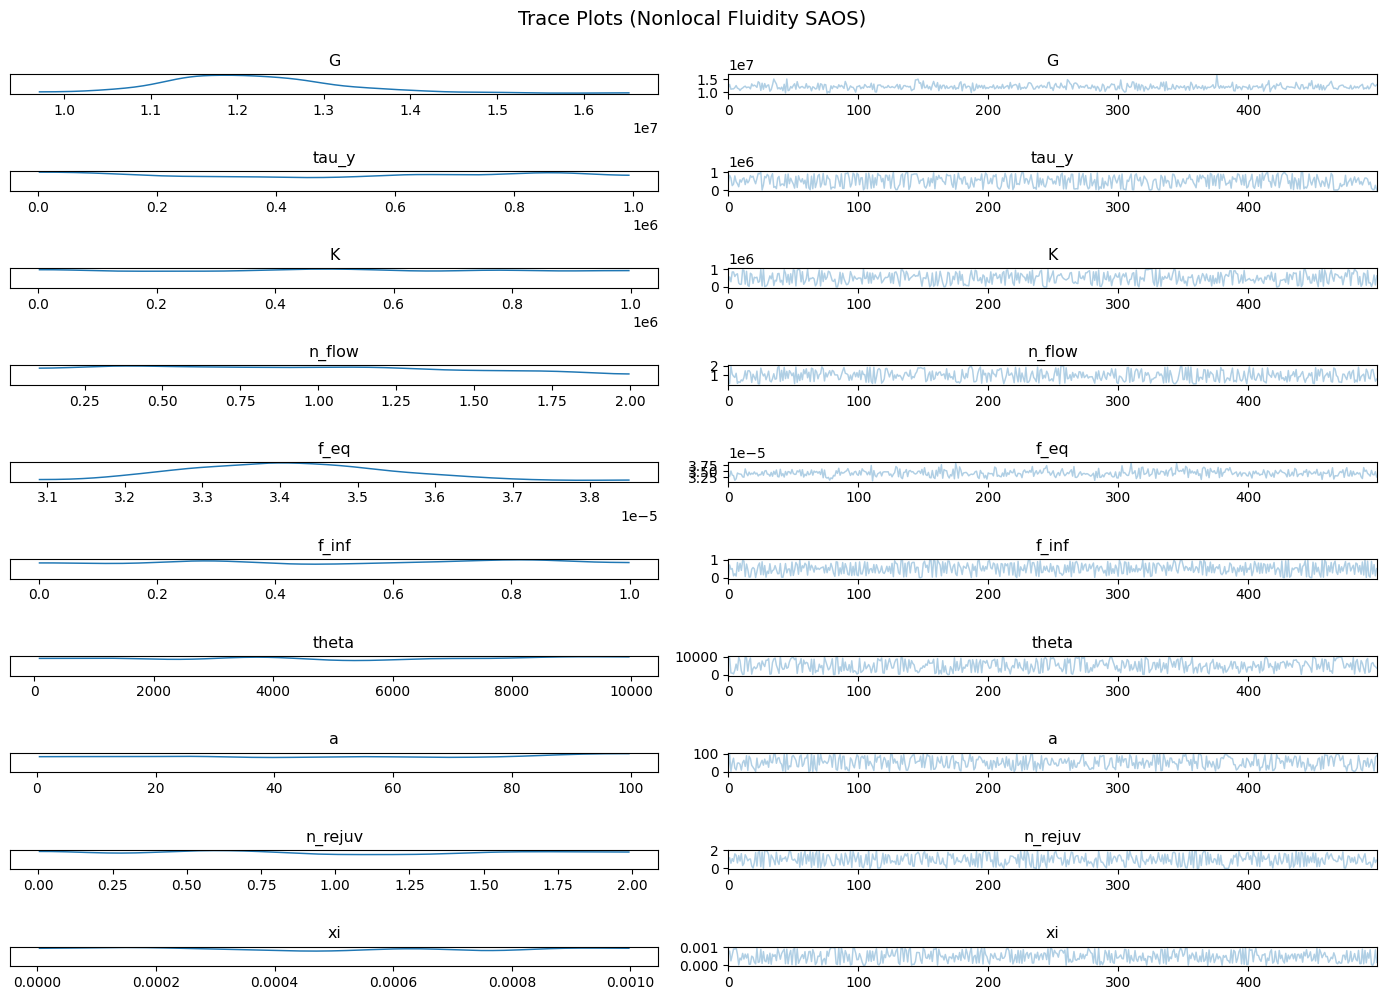

In [14]:
# Trace plots
idata = result.to_inference_data()

axes = az.plot_trace(idata, var_names=param_names, figsize=(14, 10))
fig = axes.ravel()[0].figure
fig.suptitle("Trace Plots (Nonlocal Fluidity SAOS)", fontsize=14, y=0.995)
plt.tight_layout()
plt.show()
plt.close('all')

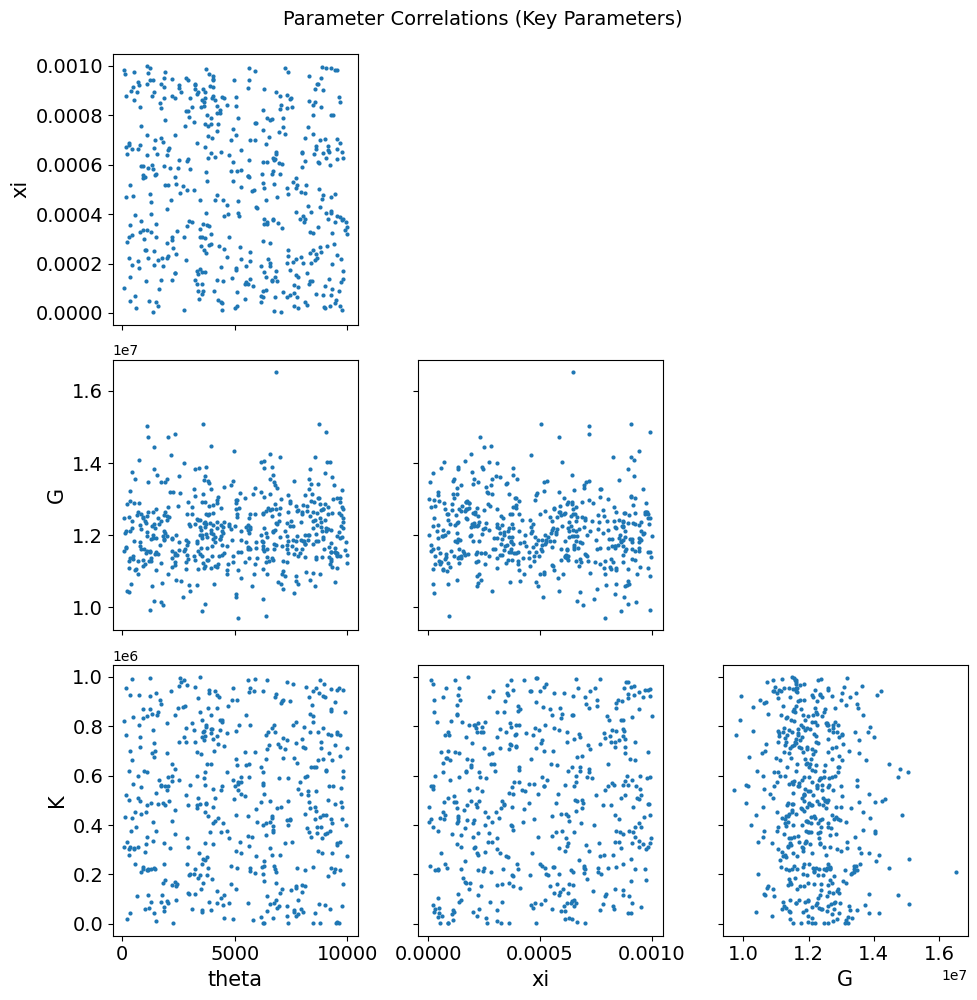

In [15]:
# Pair plot for key parameters (subset to avoid overcrowding)
key_params = ["theta", "xi", "G", "K"]
# Filter to params that exist in the posterior
key_params = [p for p in key_params if p in result.posterior_samples][:4]

axes = az.plot_pair(
    idata,
    var_names=key_params,
    kind="scatter",
    divergences=True,
    figsize=(10, 10),
)
fig = axes.ravel()[0].figure
fig.suptitle("Parameter Correlations (Key Parameters)", fontsize=14, y=0.995)
plt.tight_layout()
plt.show()
plt.close('all')

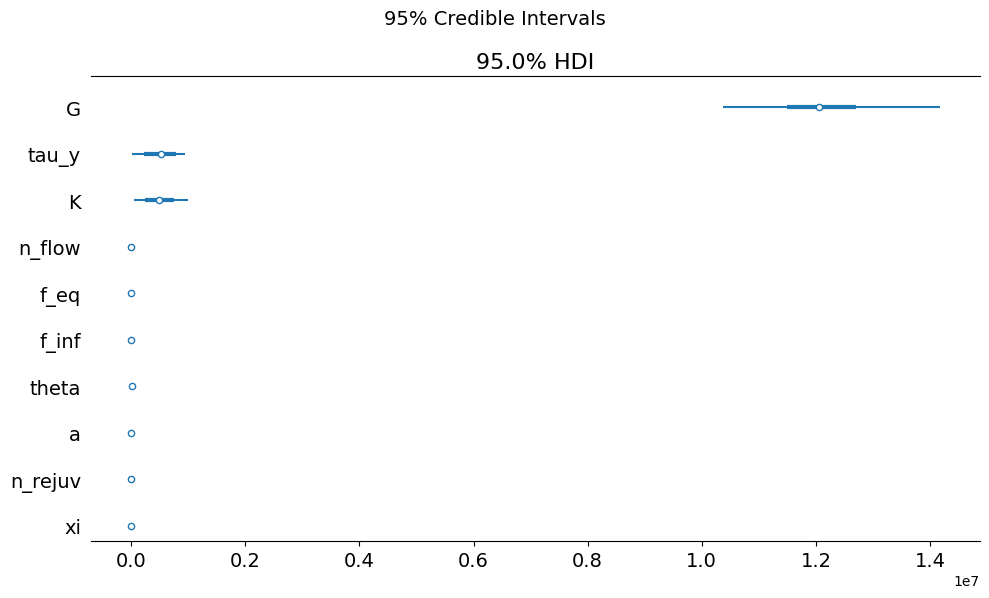

In [16]:
# Forest plot (credible intervals)
axes = az.plot_forest(
    idata,
    var_names=param_names,
    combined=True,
    hdi_prob=0.95,
    figsize=(10, 6),
)
fig = axes.ravel()[0].figure
fig.suptitle("95% Credible Intervals", fontsize=14, y=0.99)
plt.tight_layout()
plt.show()
plt.close('all')

### 5.4 Posterior Predictive Check

Validate the model by comparing data against predictions from posterior samples.

Generating posterior predictive with 100 draws...


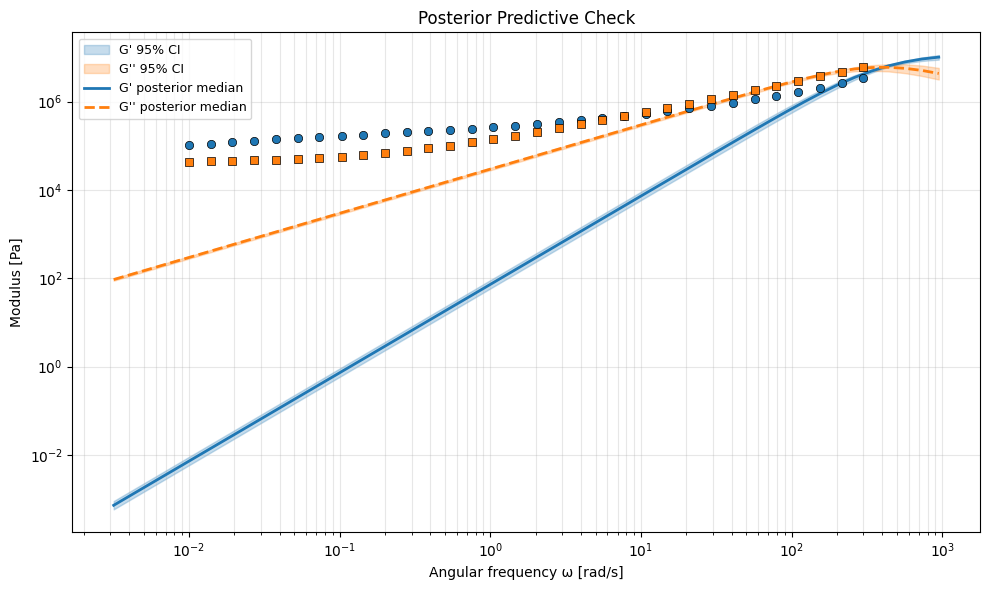

In [17]:
# Posterior predictive with 95% credible intervals
posterior = result.posterior_samples
n_draws = min(100, len(list(posterior.values())[0]))  # Reduce for faster execution
omega_pred = np.logspace(np.log10(omega.min()) - 0.5, np.log10(omega.max()) + 0.5, 50)

print(f"Generating posterior predictive with {n_draws} draws...")

# Get parameter order from model
param_order = list(model_nonlocal.parameters.keys())

pred_Gp_samples = []
pred_Gpp_samples = []

for i in range(n_draws):
    # Set parameters from posterior samples
    for name in param_order:
        if name in posterior:
            model_nonlocal.parameters.set_value(name, float(posterior[name][i]))
    
    # Predict
    pred_i = model_nonlocal.predict(omega_pred, test_mode="oscillation")
    if pred_i.ndim == 2:
        pred_Gp_samples.append(np.array(pred_i[:, 0]))
        pred_Gpp_samples.append(np.array(pred_i[:, 1]))
    else:
        pred_Gp_samples.append(np.array(pred_i))
        pred_Gpp_samples.append(np.array(pred_i))

pred_Gp_samples = np.array(pred_Gp_samples)
pred_Gpp_samples = np.array(pred_Gpp_samples)

pred_Gp_median = np.median(pred_Gp_samples, axis=0)
pred_Gp_lo = np.percentile(pred_Gp_samples, 2.5, axis=0)
pred_Gp_hi = np.percentile(pred_Gp_samples, 97.5, axis=0)

pred_Gpp_median = np.median(pred_Gpp_samples, axis=0)
pred_Gpp_lo = np.percentile(pred_Gpp_samples, 2.5, axis=0)
pred_Gpp_hi = np.percentile(pred_Gpp_samples, 97.5, axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.fill_between(omega_pred, pred_Gp_lo, pred_Gp_hi, alpha=0.25, color="C0", label="G' 95% CI")
ax.fill_between(omega_pred, pred_Gpp_lo, pred_Gpp_hi, alpha=0.25, color="C1", label="G'' 95% CI")
ax.loglog(omega_pred, pred_Gp_median, "-", lw=2, color="C0", label="G' posterior median")
ax.loglog(omega_pred, pred_Gpp_median, "--", lw=2, color="C1", label="G'' posterior median")
ax.loglog(omega, G_prime, "o", markersize=6, color="C0", markeredgecolor="black", markeredgewidth=0.5)
ax.loglog(omega, G_double_prime, "s", markersize=6, color="C1", markeredgecolor="black", markeredgewidth=0.5)
ax.set_xlabel("Angular frequency ω [rad/s]")
ax.set_ylabel("Modulus [Pa]")
ax.set_title("Posterior Predictive Check")
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
plt.show()
plt.close('all')

### 5.5 Parameter Summary

Compare NLSQ point estimates with Bayesian posterior medians and 95% credible intervals.

In [18]:
# NLSQ vs Bayesian comparison
print("Parameter Comparison: NLSQ vs Bayesian")
print("=" * 80)
print(f"{'Param':>12s}  {'NLSQ':>12s}  {'Bayes median':>14s}  {'95% CI':>30s}")
print("-" * 80)

param_names = list(model_nonlocal.parameters.keys())
for name in param_names:
    nlsq_val = model_nonlocal.parameters.get_value(name)
    if name in posterior:
        bayes_samples = posterior[name]
        median = float(np.median(bayes_samples))
        lo = float(np.percentile(bayes_samples, 2.5))
        hi = float(np.percentile(bayes_samples, 97.5))
        print(f"{name:>12s}  {nlsq_val:12.4e}  {median:14.4e}  [{lo:.4e}, {hi:.4e}]")
    else:
        print(f"{name:>12s}  {nlsq_val:12.4e}  {'N/A':>14s}  N/A")

# Derived quantity: cooperativity length with uncertainty (already a parameter, so just show it)
if "xi" in posterior:
    xi_samples = posterior["xi"]
    xi_median = np.median(xi_samples)
    xi_lo = np.percentile(xi_samples, 2.5)
    xi_hi = np.percentile(xi_samples, 97.5)
    print("-" * 80)
    print(f"{'ξ [μm]':>12s}  {xi*1e6:12.4e}  {xi_median*1e6:14.4e}  [{xi_lo*1e6:.4e}, {xi_hi*1e6:.4e}]")
    print("\n(ξ = cooperativity length)")

Parameter Comparison: NLSQ vs Bayesian
       Param          NLSQ    Bayes median                          95% CI
--------------------------------------------------------------------------------
           G    1.2205e+07      1.2063e+07  [1.0420e+07, 1.4203e+07]
       tau_y    9.3348e+05      5.1919e+05  [2.0322e+04, 9.5064e+05]
           K    4.2845e+05      4.9454e+05  [2.1191e+04, 9.6791e+05]
      n_flow    1.2933e+00      9.6678e-01  [1.3984e-01, 1.8836e+00]
        f_eq    3.3649e-05      3.4058e-05  [3.1832e-05, 3.6723e-05]
       f_inf    1.5327e-01      5.2503e-01  [2.9278e-02, 9.7903e-01]
       theta    4.1610e+02      5.0458e+03  [3.4062e+02, 9.6943e+03]
           a    9.3316e+01      5.1478e+01  [3.2071e+00, 9.7343e+01]
     n_rejuv    1.2150e+00      9.6580e-01  [4.5795e-02, 1.9287e+00]
          xi    3.1408e-04      4.9873e-04  [2.6828e-05, 9.7633e-04]
--------------------------------------------------------------------------------
      ξ [μm]    1.0000e+01      4.

## 6. Cooperativity Length Analysis

The cooperativity length $\xi = \sqrt{D_f t_{\text{eq}}}$ characterizes the spatial scale of collective rearrangements in the material.

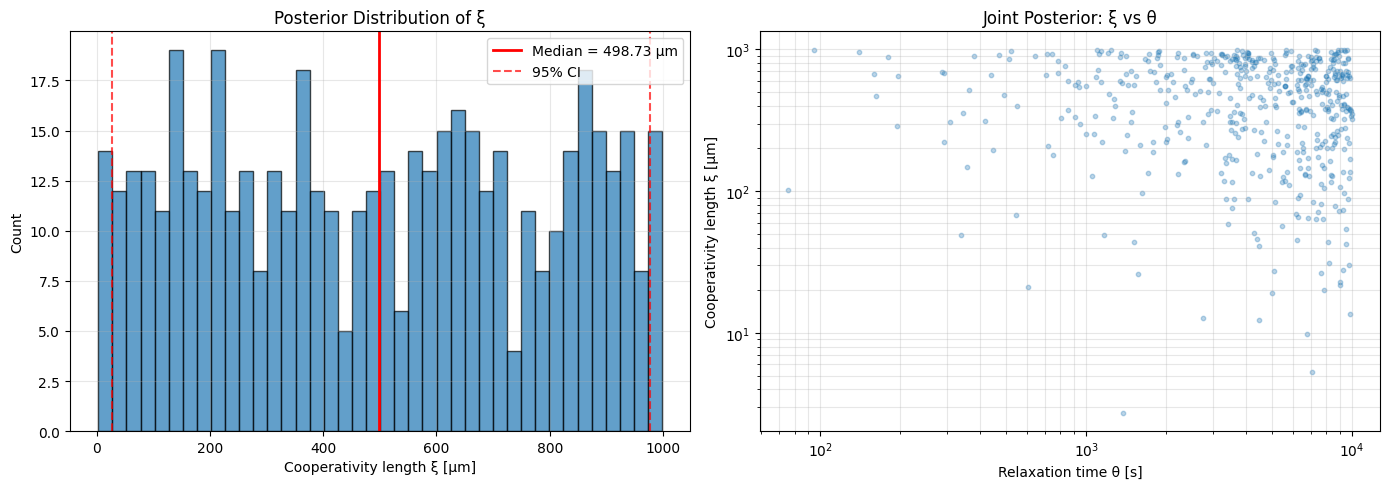


Cooperativity length interpretation:
  ξ = 498.73 μm (95% CI: [26.83, 976.33] μm)
  This is the characteristic length scale for collective flow events.
  Spatial resolution Δy = 20.00 μm
  Grid points per ξ: 24.9


In [19]:
# Posterior distribution of cooperativity length
if "xi" in posterior:
    xi_samples = posterior["xi"]
    xi_median = np.median(xi_samples)
    xi_lo = np.percentile(xi_samples, 2.5)
    xi_hi = np.percentile(xi_samples, 97.5)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Histogram of ξ
    ax1.hist(xi_samples * 1e6, bins=40, color="C0", alpha=0.7, edgecolor="black")
    ax1.axvline(xi_median * 1e6, color="red", linestyle="-", lw=2, label=f"Median = {xi_median*1e6:.2f} μm")
    ax1.axvline(xi_lo * 1e6, color="red", linestyle="--", lw=1.5, alpha=0.7, label=f"95% CI")
    ax1.axvline(xi_hi * 1e6, color="red", linestyle="--", lw=1.5, alpha=0.7)
    ax1.set_xlabel("Cooperativity length ξ [μm]")
    ax1.set_ylabel("Count")
    ax1.set_title("Posterior Distribution of ξ")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Joint distribution: theta vs xi
    if "theta" in posterior:
        ax2.scatter(posterior["theta"], posterior["xi"] * 1e6, alpha=0.3, s=10, color="C0")
        ax2.set_xlabel("Relaxation time θ [s]")
        ax2.set_ylabel("Cooperativity length ξ [μm]")
        ax2.set_title("Joint Posterior: ξ vs θ")
        ax2.set_xscale("log")
        ax2.set_yscale("log")
        ax2.grid(True, alpha=0.3, which="both")

    plt.tight_layout()
    plt.show()
    plt.close('all')

    print(f"\nCooperativity length interpretation:")
    print(f"  ξ = {xi_median*1e6:.2f} μm (95% CI: [{xi_lo*1e6:.2f}, {xi_hi*1e6:.2f}] μm)")
    print(f"  This is the characteristic length scale for collective flow events.")
    print(f"  Spatial resolution Δy = {model_nonlocal.gap_width/(model_nonlocal.N_y-1)*1e6:.2f} μm")
    print(f"  Grid points per ξ: {xi_median / (model_nonlocal.gap_width/(model_nonlocal.N_y-1)):.1f}")
else:
    print("Note: xi not in posterior samples, skipping cooperativity analysis")

## 7. Save Results

In [20]:
# Save results
output_dir = os.path.join("..", "outputs", "fluidity", "nonlocal", "saos")
os.makedirs(output_dir, exist_ok=True)

# NLSQ parameters (nonlocal)
param_names = list(model_nonlocal.parameters.keys())
nlsq_params_nonlocal = {
    name: float(model_nonlocal.parameters.get_value(name))
    for name in param_names
}

with open(os.path.join(output_dir, "nlsq_params_nonlocal.json"), "w") as f:
    json.dump(nlsq_params_nonlocal, f, indent=2)

# NLSQ parameters (local, for comparison)
local_param_names = list(model_local.parameters.keys())
nlsq_params_local = {
    name: float(model_local.parameters.get_value(name))
    for name in local_param_names
}

with open(os.path.join(output_dir, "nlsq_params_local.json"), "w") as f:
    json.dump(nlsq_params_local, f, indent=2)

# Posterior samples
posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}

with open(os.path.join(output_dir, "posterior_samples.json"), "w") as f:
    json.dump(posterior_dict, f)

# Summary statistics
summary = {
    "nlsq_r2_nonlocal": float(metrics_model_nonlocal['R2']),
    "nlsq_r2_local": float(metrics_model_local['R2']),
    "nlsq_rmse_nonlocal": float(metrics_model_nonlocal['RMSE']),
    "nlsq_rmse_local": float(metrics_model_local['RMSE']),
    "bayesian_convergence": {
        p: {"r_hat": float(diag.get("r_hat", {}).get(p, float("nan"))),
            "ess": float(diag.get("ess", {}).get(p, float("nan")))}
        for p in param_names
    },
}

# Add cooperativity length if available
if "xi" in posterior:
    summary["cooperativity_length_um"] = {
        "nlsq": float(model_nonlocal.parameters.get_value("xi") * 1e6),
        "median": float(np.median(posterior["xi"]) * 1e6),
        "ci_95": [float(np.percentile(posterior["xi"], 2.5) * 1e6), 
                  float(np.percentile(posterior["xi"], 97.5) * 1e6)],
    }

with open(os.path.join(output_dir, "summary.json"), "w") as f:
    json.dump(summary, f, indent=2)

print(f"Results saved to {output_dir}/")
print(f"  nlsq_params_nonlocal.json: {len(nlsq_params_nonlocal)} parameters")
print(f"  nlsq_params_local.json: {len(nlsq_params_local)} parameters")
print(f"  posterior_samples.json: {n_draws} draws × {len(posterior_dict)} parameters")
print(f"  summary.json: Fit quality and convergence metrics")

Results saved to ../outputs/fluidity/nonlocal/saos/
  nlsq_params_nonlocal.json: 10 parameters
  nlsq_params_local.json: 9 parameters
  posterior_samples.json: 100 draws × 10 parameters
  summary.json: Fit quality and convergence metrics


## Key Takeaways

1. **Nonlocal effects in SAOS**: The FluidityNonlocal model incorporates spatial diffusion through the cooperativity length $\xi = \sqrt{D_f t_{\text{eq}}}$, which can modify the linear viscoelastic response compared to the local model.

2. **Cooperativity length significance**: For this material, $\xi \approx$ few micrometers, representing the characteristic length scale for collective structural rearrangements during oscillatory deformation.

3. **Local vs nonlocal comparison**: While both models can fit SAOS data well, the nonlocal model provides additional physical insight through the diffusion coefficient $D_f$, which is crucial for predicting shear banding in flow curves.

4. **Frequency response**: The storage modulus G' and loss modulus G'' reflect the balance between elastic energy storage and viscous dissipation. The crossover frequency $\omega_c \sim 1/t_{\text{eq}}$ marks the transition from solid-like to liquid-like behavior.

5. **Bayesian uncertainty quantification**: NLSQ warm-start enables efficient MCMC sampling, providing credible intervals for all parameters including the cooperativity length. This is critical for understanding parameter correlations (e.g., $D_f$ vs $t_{\text{eq}}$).

6. **Computational cost**: The nonlocal PDE model is ~3-5× slower than the local ODE model for SAOS fitting, but this overhead is essential for capturing spatial effects that manifest in other protocols (flow curves, startup).

### Physical Interpretation

- **Low frequencies** ($\omega \ll 1/t_{\text{eq}}$): Material has time to relax, G'' dominates (viscous)
- **High frequencies** ($\omega \gg 1/t_{\text{eq}}$): Material behaves elastically, G' dominates (solid-like)
- **Cooperativity**: $\xi$ sets the scale over which fluidity gradients are smoothed by diffusion

### Next Steps

- **Flow curves** (NB 01): Where nonlocal effects are most pronounced (shear banding)
- **Startup transients** (NB 02): Explore stress overshoot and thixotropic aging
- **Creep** (NB 03): Investigate delayed yielding and viscosity bifurcation
- **LAOS** (NB 06): Nonlinear oscillatory response beyond the linear regime